# Desafio Codenation: Descubra as melhores notas de matemática do ENEM 2016

## Introdução

O objetivo [desse desafio](https://www.codenation.dev/acceleration/aceleradev-data-science/challenge/enem-ps) é criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016.

## Notebook setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, accuracy_score

from lightgbm import LGBMRegressor

/anaconda3/envs/tera-env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
plt.style.use('ggplot')

## Os dados

Os dados que nos foram disponibilizados consistem de informações demográficas dos participantes do ENEM 2016, bem como as notas que estes atingiram nas diversas provas que o compõem.

In [4]:
data = pd.read_csv('train.csv', header=0)

In [5]:
data.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [6]:
data.shape

(13730, 167)

## Limpando os dados

Como vemos acima, temos 167 colunas no dataset. Vamos vou começar excluindo as colunas que eu não vou usar em nenhum momento. Para isso, consultei o *Dicionário dos Microdados do Enem 2016* (disponível nesse repo).

In [7]:
cols_to_drop = ['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA',
                'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC',
                'IN_CERTIFICADO', 'NO_ENTIDADE_CERTIFICACAO', 'CO_UF_ENTIDADE_CERTIFICACAO',
                'SG_UF_ENTIDADE_CERTIFICACAO', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'TX_RESPOSTAS_CN',
                'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
                'TX_GABARITO_LC', 'TX_GABARITO_MT']

data.drop(cols_to_drop, axis=1, inplace=True)

In [8]:
data.shape

(13730, 144)

Ainda sobraram 144 colunas que acho que potencialmente podem ser features interessantes. Para começar minha análise, eu vou começar com algumas colunas que eu suspeito serão as mais relevantes. No próximo notebook eu aprimoro meu modelo incluindo outras colunas.

As colunas que eu vou usar como features inicialmente são:

- `NU_IDADE`:
    - Idade
    - Idades inferiores a 10 anos e superiores a 100 anos estão com o campo vazio na base
- `TP_SEXO`:
    - Sexo
    - Categorias:
        - `M`: masculino
        - `F`: feminino
- `TP_ESTADO_CIVIL`:
    - Estado civil
    - Categorias:
        - `0`: solteiro
        - `1`: casado/mora junto
        - `2`: divorciado
        - `3`: viúvo
- `TP_COR_RACA`:
    - Cor/raça
    - Categorias:
        - `0`: não declarado
        - `1`: branca
        - `2`: preta
        - `3`: parda
        - `4`: amarela
        - `5`: indígena
        - `6`: não dispõe da informação
- `TP_NACIONALIDADE`:
    - Nacionalidade
    - Categorias:
        - `0`: não informado
        - `1`: brasileiro
        - `2`: brasileiro naturalizado
        - `3`: estrangeiro
        - `4`: brasileiro nato, nascido no exterior
- `TP_ST_CONCLUSAO`:
    - Situação de conclusão do Ensino Médio
    - Categorias:
        - `1`: já concluiu
        - `2`: cursando e concluirá em 2016
        - `3`: cursando e concluirá após 2016
        - `4`: não concluiu e não está cursando
- `TP_ANO_CONCLUIU`:
    - Ano de conclusão do Ensino Médio
    - Categorias:
        - `0`: não informado
        - `1`: 2015
        - ...
        - `9`: 2007
        - `10`: anterior a 2007
- `TP_ESCOLA`:
    - Tipo de escola do Ensino Médio
    - Categorias:
        - `1`: não respondeu
        - `2`: pública
        - `3`: privada
        - `4`: exterior
- `TP_ENSINO`:
    - Tipo de instituição que concluiu ou concluirá o Ensino Médio
    - Categorias:
        - `1`: ensino regular
        - `2`: educação especial - modalidade substitutiva
        - `3`: educação de jovens e adultos
- `IN_TREINEIRO`:
    - Inscrito fez a prova com intuito de apenas treinar seus conhecimentos?
    - Categorias:
        - `0`: não
        - `1`: sim
- `NU_NOTA_CN`:
    - Nota da prova de ciências da natureza
- `NU_NOTA_CH`:
    - Nota da prova de ciências humanas
- `NU_NOTA_LC`:
    - Nota da prova de linguagens e códigos
- `NU_NOTA_MT`:
    - Nota da prova de matemática
- `TP_LINGUA`:
    - Língua estrangeira
    - Categorias:
        - `0`: inglês
        - `1`: espanhol
- `NU_NOTA_REDACAO`:
    - Nota da prova de redação
- `Q001`:
    - Até que série seu pai, ou o homem responsável por você, estudou?
    - Categorias:
        - `A`: nunca estudou
        - `B`: não completou a 4ª série/5º ano do Ensino Fundamental
        - `C`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
        - `D`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
        - `E`: completou o Ensino Médio, mas não completou a Faculdade
        - `F`: completou a Faculdade, mas não completou a Pós-graduação
        - `G`: completou a Pós-graduação
        - `H`: não sei
- `Q002`:
    - Até que série sua mãe, ou a mulher responsável por você, estudou?
    - Categorias:
        - `A`: nunca estudou
        - `B`: não completou a 4ª série/5º ano do Ensino Fundamental
        - `C`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
        - `D`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
        - `E`: completou o Ensino Médio, mas não completou a Faculdade
        - `F`: completou a Faculdade, mas não completou a Pós-graduação
        - `G`: completou a Pós-graduação
        - `H`: não sei
- `Q006`:
    - Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)
    - Categorias:
        - `A`: nenhuma renda
        - `B`: até R\$ 880
        - ...
        - `Q`: mais de R$ 17.600,00
- `Q026`:
    - Você exerce ou já exerceu atividade remunerada?
    - Categorias:
        - `A`: não, nunca trabalhei
        - `B`: sim, já trabalhei, mas não estou trabalhando
        - `C`: sim, estou trabalhando

In [9]:
feat_cols = ['NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
             'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH',
             'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q026']

df = data[feat_cols]

In [10]:
df.head()

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,NU_NOTA_REDACAO,Q001,Q002,Q006,Q026
0,24,M,1,1,1,4,1,NaN,0,436.3,495.4,581.2,399.4,1,520.0,D,D,C,C
1,17,F,3,1,2,0,2,1.0,0,474.5,544.1,599.0,459.8,1,580.0,A,A,B,A
2,21,F,3,1,3,0,1,NaN,0,NaN,NaN,NaN,NaN,1,NaN,D,D,C,A
3,25,F,0,1,1,9,1,NaN,0,NaN,NaN,NaN,NaN,0,NaN,H,E,E,C
4,28,M,2,1,1,4,1,NaN,0,NaN,NaN,NaN,NaN,1,NaN,E,D,C,B


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 19 columns):
NU_IDADE            13730 non-null int64
TP_SEXO             13730 non-null object
TP_COR_RACA         13730 non-null int64
TP_NACIONALIDADE    13730 non-null int64
TP_ST_CONCLUSAO     13730 non-null int64
TP_ANO_CONCLUIU     13730 non-null int64
TP_ESCOLA           13730 non-null int64
TP_ENSINO           4282 non-null float64
IN_TREINEIRO        13730 non-null int64
NU_NOTA_CN          10341 non-null float64
NU_NOTA_CH          10341 non-null float64
NU_NOTA_LC          10133 non-null float64
NU_NOTA_MT          10133 non-null float64
TP_LINGUA           13730 non-null int64
NU_NOTA_REDACAO     10133 non-null float64
Q001                13730 non-null object
Q002                13730 non-null object
Q006                13730 non-null object
Q026                13730 non-null object
dtypes: float64(6), int64(8), object(5)
memory usage: 2.0+ MB


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NU_IDADE,13730.0,21.593809,7.043654,13.0,17.0,19.0,23.0,67.0
TP_COR_RACA,13730.0,2.185652,1.007285,0.0,1.0,3.0,3.0,5.0
TP_NACIONALIDADE,13730.0,1.048871,0.258895,0.0,1.0,1.0,1.0,4.0
TP_ST_CONCLUSAO,13730.0,1.782666,0.880734,1.0,1.0,2.0,2.0,4.0
TP_ANO_CONCLUIU,13730.0,2.146176,3.217328,0.0,0.0,0.0,3.0,10.0
TP_ESCOLA,13730.0,1.353532,0.558472,1.0,1.0,1.0,2.0,4.0
TP_ENSINO,4282.0,1.178888,0.565490,1.0,1.0,1.0,1.0,3.0
IN_TREINEIRO,13730.0,0.129862,0.336163,0.0,0.0,0.0,0.0,1.0
NU_NOTA_CN,10341.0,473.495155,71.093674,0.0,419.9,459.8,514.5,806.4
NU_NOTA_CH,10341.0,529.661087,73.726344,0.0,480.4,532.0,581.2,807.0


## EDA, lidando com nulos e feature engineering

As variáveis com o maior número de nulos são:

In [13]:
df.isna().mean().sort_values(ascending=False)

TP_ENSINO           0.688128
NU_NOTA_REDACAO     0.261981
NU_NOTA_MT          0.261981
NU_NOTA_LC          0.261981
NU_NOTA_CN          0.246832
NU_NOTA_CH          0.246832
TP_ESCOLA           0.000000
TP_SEXO             0.000000
TP_COR_RACA         0.000000
TP_NACIONALIDADE    0.000000
TP_ST_CONCLUSAO     0.000000
TP_ANO_CONCLUIU     0.000000
Q026                0.000000
IN_TREINEIRO        0.000000
Q006                0.000000
TP_LINGUA           0.000000
Q001                0.000000
Q002                0.000000
NU_IDADE            0.000000
dtype: float64

### TP_ENSINO

Corresonde ao tipo de instituição que concluiu ou concluirá o Ensino Médio, onde:

- `1`: ensino regular
- `2`: educação especial - modalidade substitutiva
- `3`: educação de jovens e adultos

Quase 70% das observações nessa variável são nulas, mas acho que isso ainda pode ser uma feature interessante, então vou optar por manter esta variável e imputar os nulos com -1.

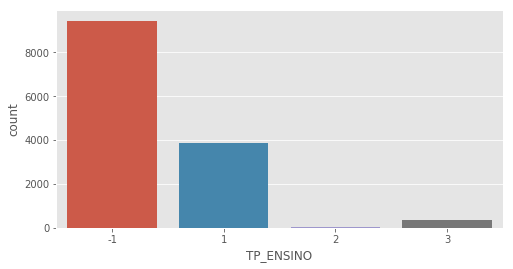

<Figure size 432x288 with 0 Axes>

In [14]:
df['TP_ENSINO'] = df['TP_ENSINO'].fillna(-1)

df['TP_ENSINO'] = df['TP_ENSINO'].astype('int')

ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_ENSINO', data=df)
plt.show()
plt.clf()

In [15]:
df.groupby('TP_ENSINO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ENSINO,,,,,,,,
-1,6494.0,483.919587,99.941466,0.0,409.90,462.75,540.575,935.1
1,3386.0,482.282398,100.961588,0.0,408.90,460.00,535.975,952.0
2,23.0,464.982609,85.814984,376.4,384.45,447.20,522.950,691.9
3,230.0,447.282174,70.637989,335.4,394.00,429.55,490.900,712.3


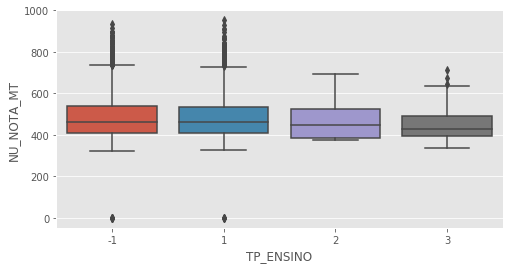

<Figure size 432x288 with 0 Axes>

In [16]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_ENSINO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### NU_NOTA_X

Corresponde à nota em cada umas das provas.

Cerca de 1/4 das observações em cada uma dessas variáveis estão nulas e, pelo que podemos observar abaixo, na maioria dos casos, observações com nulos em uma dessas variáveis também terão nulos nas outras variáveis correspondentes.

In [17]:
NU_NOTA_X = ['NU_NOTA_REDACAO', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']

In [18]:
df[NU_NOTA_X].head(n=20)

,NU_NOTA_REDACAO,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN
0,520.0,399.4,581.2,495.4,436.3
1,580.0,459.8,599.0,544.1,474.5
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,620.0,364.5,410.9,583.2,439.7
6,560.0,529.2,484.5,604.2,420.1
7,620.0,566.7,611.2,625.8,619.6
8,680.0,372.4,521.8,555.2,500.5
9,NaN,NaN,NaN,NaN,NaN


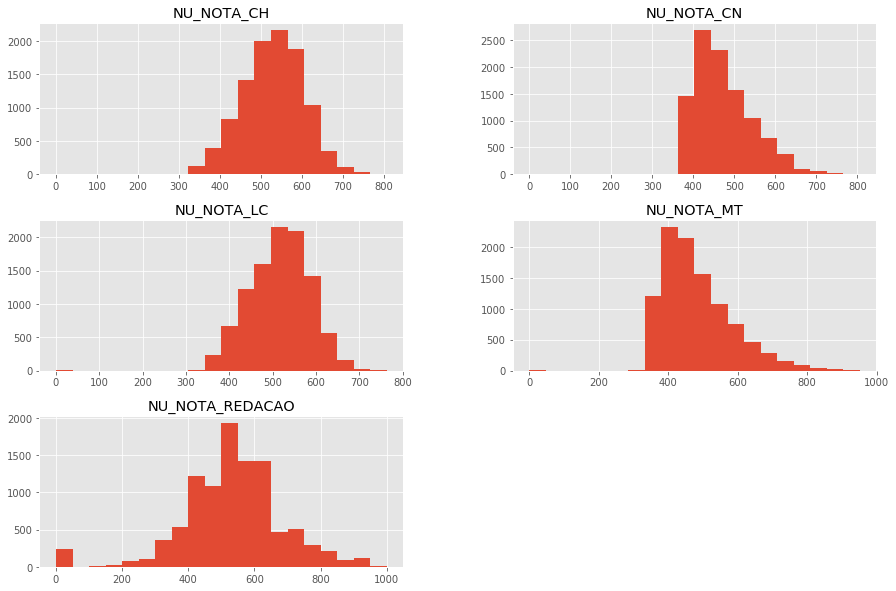

<Figure size 432x288 with 0 Axes>

In [19]:
df[NU_NOTA_X].hist(bins=20, figsize=(15, 10))
plt.show()
plt.clf()

Eu não sei ao certo, mas eu suspeito de que os nulos nessas variáveis correspondem aos indivíduos que não entregaram a prova. Sendo assim, eu imputarei nota zero aos nulos.

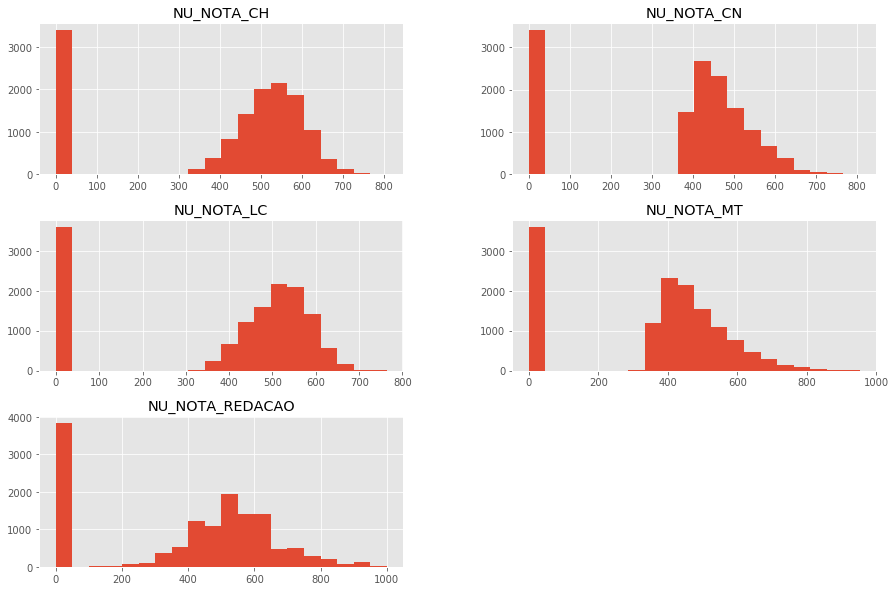

<Figure size 432x288 with 0 Axes>

In [20]:
df[NU_NOTA_X] = df[NU_NOTA_X].fillna(0.0)

df[NU_NOTA_X].hist(bins=20, figsize=(15, 10))
plt.show()
plt.clf()

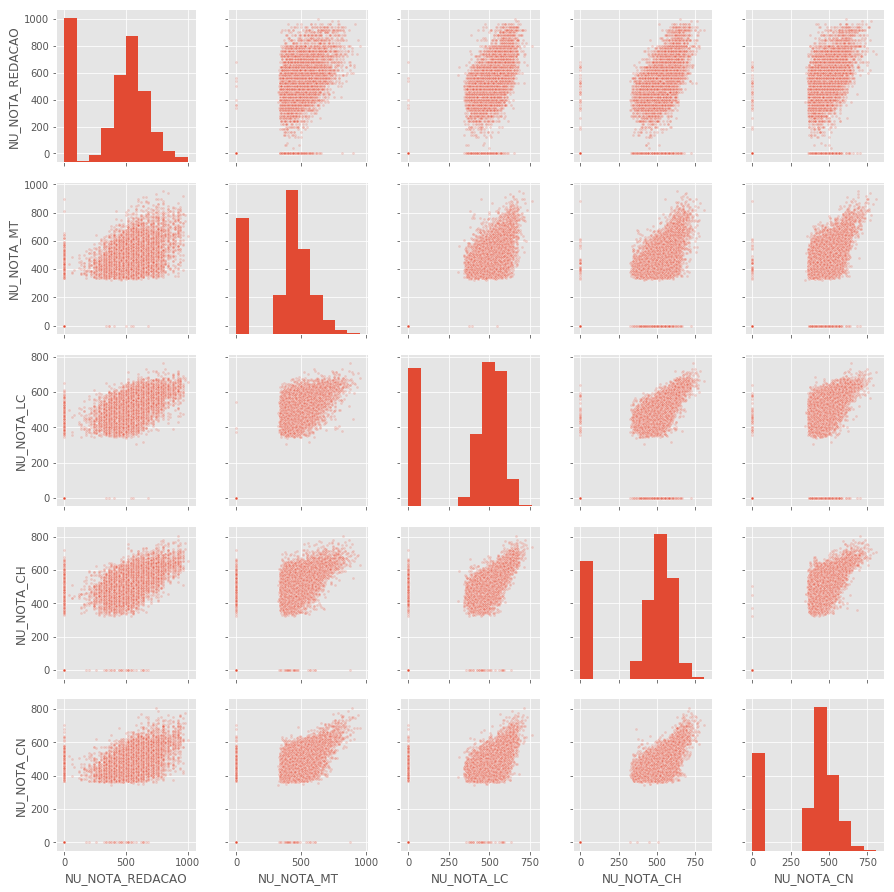

<Figure size 432x288 with 0 Axes>

In [21]:
sns.pairplot(df[NU_NOTA_X], plot_kws={'alpha': 0.2, 'marker': '.'})
plt.show()
plt.clf()

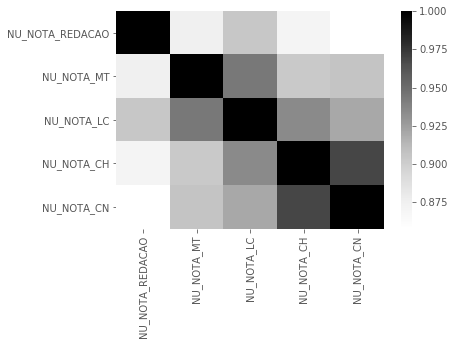

<Figure size 432x288 with 0 Axes>

In [22]:
corr_notas = df[NU_NOTA_X].corr()

sns.heatmap(corr_notas, cmap='Greys')
plt.show()
plt.clf()

Como era de se esperar, a correlação entre as notas que um indivíduo obteve em cada uma das provas é bem alta (ou seja, se ele foi bem em uma das provas, ele provavelmente também foi bem nas outras provas), sendo que a prova com a maior correlação com sua nota em matemática é a de linguagens e códigos.

### Q026 - Trabalha?

Corresponde à pergunta "Você exerce ou já exerceu atividade remunerada?" do questionário socioeconômico, onde:

- `A`: não, nunca trabalhei
- `B`: sim, já trabalhei, mas não estou trabalhando
- `C`: sim, estou trabalhando

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `0`: não, nunca trabalhei
- `1`: sim, já trabalhei, mas não estou trabalhando
- `2`: sim, estou trabalhando

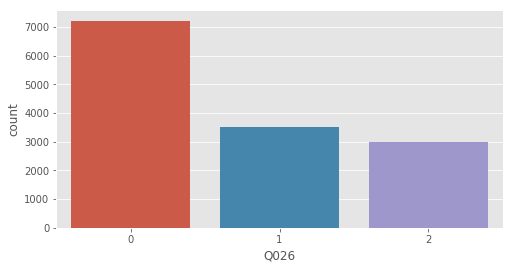

<Figure size 432x288 with 0 Axes>

In [23]:
le = LabelEncoder()

df['Q026'] = le.fit_transform(df['Q026'])

ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='Q026', data=df)
plt.show()
plt.clf()

In [24]:
df.groupby('Q026').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q026,,,,,,,,
0,7215.0,403.291365,203.460212,0.0,374.9,437.4,519.15,952.0
1,3509.0,302.669023,244.968485,0.0,0.0,403.7,489.30,895.5
2,3006.0,305.169228,241.979716,0.0,0.0,403.4,487.40,878.3


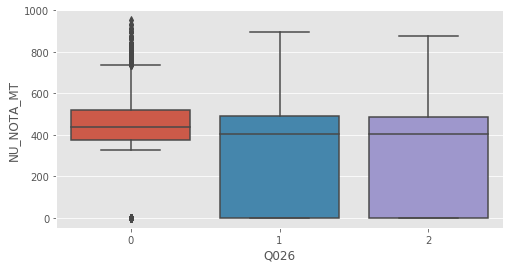

<Figure size 432x288 with 0 Axes>

In [25]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='Q026', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_ANO_CONCLUIU

Corresponde ao ano de conclusão do Ensino Médio, onde:

- `0`: não informado
- `1`: 2015
- ...
- `9`: 2007
- `10`: anterior a 2007

Vemos que os nulos estão na catergoria `0` e, conforme o gráfico abaixo, correspondem à marioria das observações. Assumo que isso seja porque a maioria dos indivíduos fazendo a prova ainda não concluiu o Ensino Médio.

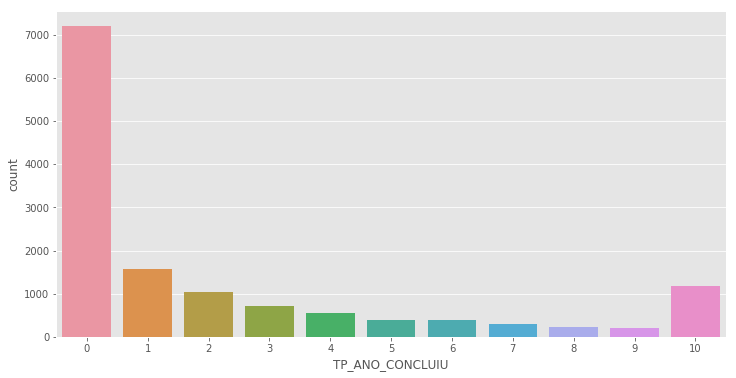

<Figure size 432x288 with 0 Axes>

In [26]:
ax, fig = plt.subplots(figsize=(12, 6))

sns.countplot(x='TP_ANO_CONCLUIU', data=df)
plt.show()
plt.clf()

In [27]:
df.groupby('TP_ANO_CONCLUIU').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ANO_CONCLUIU,,,,,,,,
0,7206.0,382.063322,207.897328,0.0,365.300,429.60,506.000,952.0
1,1578.0,391.581749,225.457790,0.0,359.325,438.75,536.175,916.6
2,1033.0,368.063698,232.998690,0.0,0.000,428.60,521.000,935.1
3,712.0,347.186657,243.264350,0.0,0.000,425.75,508.750,896.3
4,563.0,314.306750,251.336858,0.0,0.000,416.20,490.000,800.1
5,379.0,294.606860,249.550994,0.0,0.000,397.60,488.550,897.0
6,383.0,270.873629,246.837446,0.0,0.000,376.30,484.550,788.2
7,294.0,292.084354,252.487986,0.0,0.000,387.30,488.775,843.9
8,221.0,280.998190,258.348113,0.0,0.000,392.60,492.400,854.7


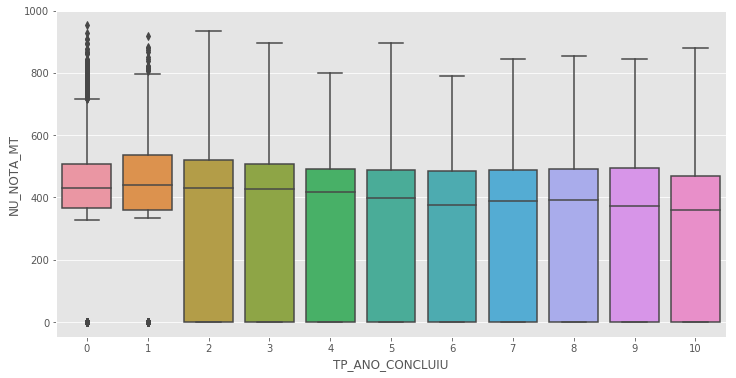

<Figure size 432x288 with 0 Axes>

In [28]:
ax, fig = plt.subplots(figsize=(12, 6))

sns.boxplot(x='TP_ANO_CONCLUIU', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_SEXO

Corresponde ao sexo, onde:

- `M`: masculino
- `F`: feminino

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `1`: masculino
- `0`: feminino

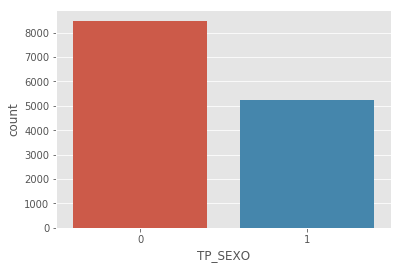

<Figure size 432x288 with 0 Axes>

In [29]:
le = LabelEncoder()

df['TP_SEXO'] = le.fit_transform(df['TP_SEXO'])

ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='TP_SEXO', data=df)
plt.show()
plt.clf()

In [30]:
df.groupby('TP_SEXO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_SEXO,,,,,,,,
0,8491.0,345.115723,220.250907,0.0,0.0,415.0,487.90,935.1
1,5239.0,373.883165,241.087030,0.0,0.0,440.4,537.55,952.0


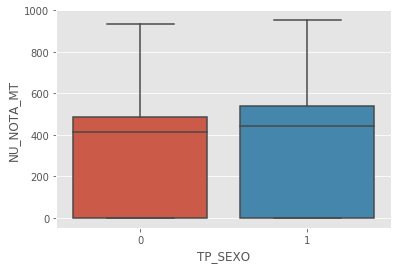

<Figure size 432x288 with 0 Axes>

In [31]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='TP_SEXO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_COR_RACA

Corresponde à cor/raça declarada, onde:

- `0`: não declarado
- `1`: branca
- `2`: preta
- `3`: parda
- `4`: amarela
- `5`: indígena
- `6`: não dispõe da informação

Apesar de a descrição dos dados permitir nulos (categoria `6`), vemos abaixo que não há nenhuma observação nessa categoria.

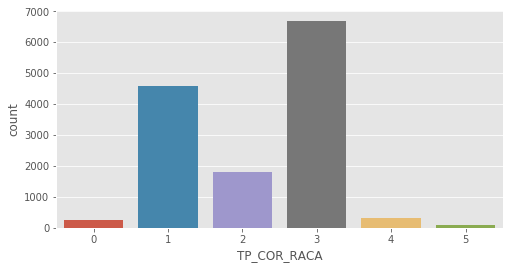

<Figure size 432x288 with 0 Axes>

In [32]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_COR_RACA', data=df)
plt.show()
plt.clf()

In [33]:
df.groupby('TP_COR_RACA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_COR_RACA,,,,,,,,
0,241.0,344.212448,246.020475,0.0,0.0,409.9,497.70,857.9
1,4589.0,383.315581,238.776759,0.0,341.9,442.5,542.30,952.0
2,1794.0,338.196042,221.555351,0.0,0.0,416.7,485.05,916.6
3,6693.0,343.581100,221.025909,0.0,0.0,415.3,487.70,909.5
4,312.0,358.315385,235.290804,0.0,0.0,425.5,502.45,928.5
5,101.0,287.670297,227.877316,0.0,0.0,396.4,453.10,712.6


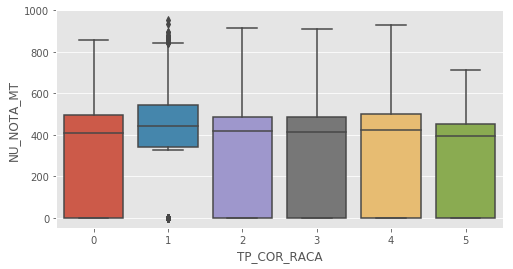

<Figure size 432x288 with 0 Axes>

In [34]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_COR_RACA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_NACIONALIDADE

Corresponde à nacionalidade, onde:

- `0`: não informado
- `1`: brasileiro
- `2`: brasileiro naturalizado
- `3`: estrangeiro
- `4`: brasileiro nato, nascido no exterior

Vemos que os nulos estão na catergoria 0 mas, conforme vemos abaixo, estes correspondem à uma fração muito pequena das observações.

In [35]:
df['TP_NACIONALIDADE'].value_counts(dropna=False)

1    13121
2      548
4       40
0       13
3        8
Name: TP_NACIONALIDADE, dtype: int64

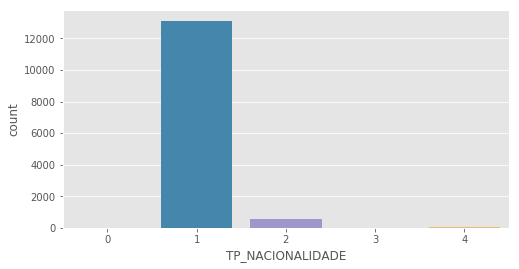

<Figure size 432x288 with 0 Axes>

In [36]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_NACIONALIDADE', data=df)
plt.show()
plt.clf()

In [37]:
df.groupby('TP_NACIONALIDADE').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_NACIONALIDADE,,,,,,,,
0,13.0,344.607692,199.476972,0.0,389.700,431.80,466.600,521.7
1,13121.0,358.346277,228.816862,0.0,0.000,423.60,506.800,952.0
2,548.0,299.677007,222.455767,0.0,0.000,400.15,459.375,724.9
3,8.0,439.287500,319.478340,0.0,283.050,433.45,682.500,840.8
4,40.0,376.820000,221.364350,0.0,362.325,428.05,519.300,752.5


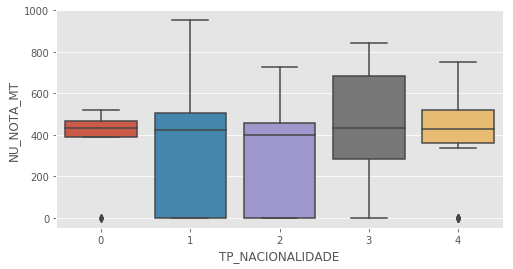

<Figure size 432x288 with 0 Axes>

In [38]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_NACIONALIDADE', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_ST_CONCLUSAO

Corresponde à situação de conclusão do Ensino Médio, onde:

- `1`: já concluiu
- `2`: cursando e concluirá em 2016
- `3`: cursando e concluirá após 2016
- `4`: não concluiu e não está cursando

Não há valores nulos.

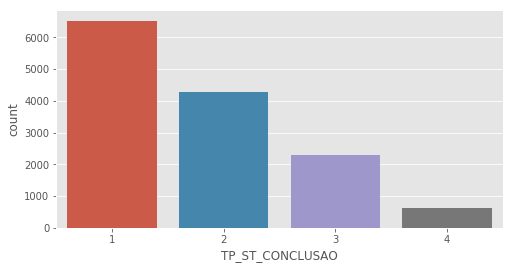

<Figure size 432x288 with 0 Axes>

In [39]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_ST_CONCLUSAO', data=df)
plt.show()
plt.clf()

In [40]:
df.groupby('TP_ST_CONCLUSAO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ST_CONCLUSAO,,,,,,,,
1,6524.0,327.406990,246.808545,0.0,0.0,413.7,503.50,935.1
2,4283.0,407.876955,194.482847,0.0,379.7,439.9,516.50,952.0
3,2306.0,378.716088,203.557987,0.0,365.3,427.9,499.85,895.4
4,617.0,215.384117,234.652286,0.0,0.0,0.0,443.30,681.8


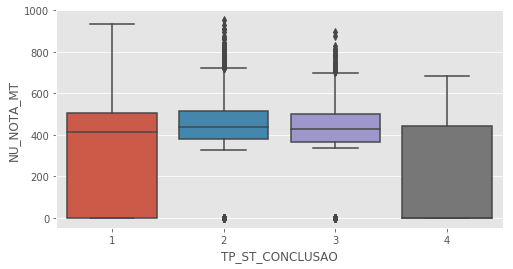

<Figure size 432x288 with 0 Axes>

In [41]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_ST_CONCLUSAO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### IN_TREINEIRO

Corresponde a se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos, onde:

- `0`: não
- `1`: sim

Não há valores nulos.

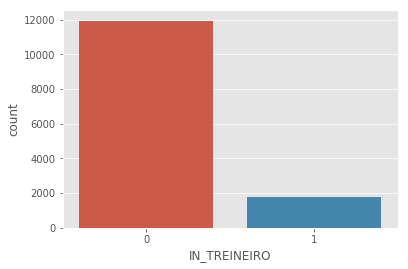

<Figure size 432x288 with 0 Axes>

In [42]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='IN_TREINEIRO', data=df)
plt.show()
plt.clf()

In [43]:
df.groupby('IN_TREINEIRO').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
IN_TREINEIRO,,,,,,,,
0,11947.0,349.126048,232.900794,0.0,0.0,420.1,503.2,952.0
1,1783.0,402.772070,193.226999,0.0,377.2,438.6,513.5,895.4


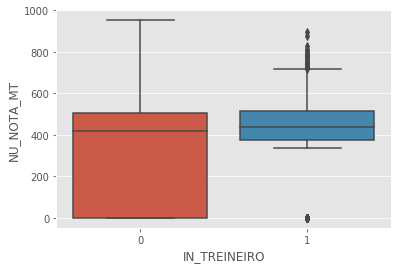

<Figure size 432x288 with 0 Axes>

In [44]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='IN_TREINEIRO', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_ESCOLA

Corresponde ao tipo de escola do Ensino Médio, onde:

- `1`: não respondeu
- `2`: pública
- `3`: privada
- `4`: exterior

Vemos que os nulos estão na catergoria `1` e, conforme vemos abaixo, correspondem à maioria das observações.

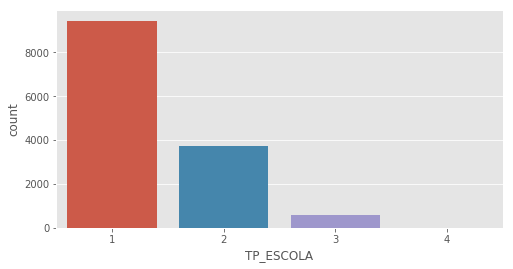

<Figure size 432x288 with 0 Axes>

In [45]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.countplot(x='TP_ESCOLA', data=df)
plt.show()
plt.clf()

In [46]:
df.groupby('TP_ESCOLA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_ESCOLA,,,,,,,,
1,9447.0,332.615063,239.169388,0.0,0.0,414.5,498.65,935.1
2,3713.0,386.208161,187.878882,0.0,373.2,427.9,494.90,877.4
3,569.0,549.361687,177.008949,0.0,454.6,564.1,665.10,952.0
4,1.0,359.300000,NaN,359.3,359.3,359.3,359.30,359.3


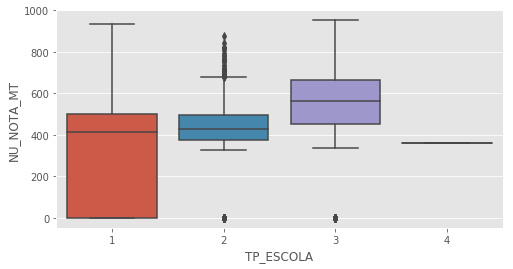

<Figure size 432x288 with 0 Axes>

In [47]:
ax, fig = plt.subplots(figsize=(8, 4))

sns.boxplot(x='TP_ESCOLA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### Q006 - Renda mensal

Corresponde à pergunta "Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)" do questionário socioeconômico, onde:
 
 - `A`: nenhuma renda
 - `B`: até R\$ 880
 - ...
 - `Q`: mais de R$ 17.600,00
 
Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

 - `0`: nenhuma renda
 - `1`: até R\$ 880
 - ...
 - `16`: mais de R$ 17.600,00

In [48]:
le = LabelEncoder()

df['Q006'] = le.fit_transform(df['Q006'])

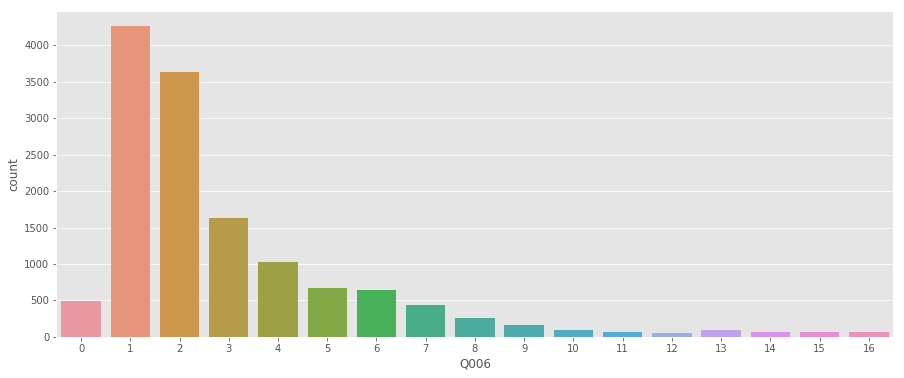

<Figure size 432x288 with 0 Axes>

In [49]:
ax, fig = plt.subplots(figsize=(15, 6))

sns.countplot(x='Q006', data=df)
plt.show()
plt.clf()

In [50]:
df.groupby('Q006').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q006,,,,,,,,
0,491.0,301.232587,220.822728,0.0,0.000,392.10,451.900,840.9
1,4264.0,332.438039,207.209400,0.0,0.000,407.20,468.500,800.2
2,3641.0,329.317715,226.158232,0.0,0.000,413.80,486.600,896.3
3,1636.0,344.026284,232.372639,0.0,0.000,426.00,506.400,895.5
4,1028.0,367.003502,231.437298,0.0,0.000,427.00,523.300,952.0
5,667.0,383.779910,239.669104,0.0,335.350,442.70,549.550,874.1
6,642.0,402.330530,237.088261,0.0,371.175,469.45,552.850,829.1
7,433.0,457.927483,224.677898,0.0,407.700,507.20,600.700,877.6
8,253.0,484.933597,218.121805,0.0,423.800,518.40,636.400,895.4


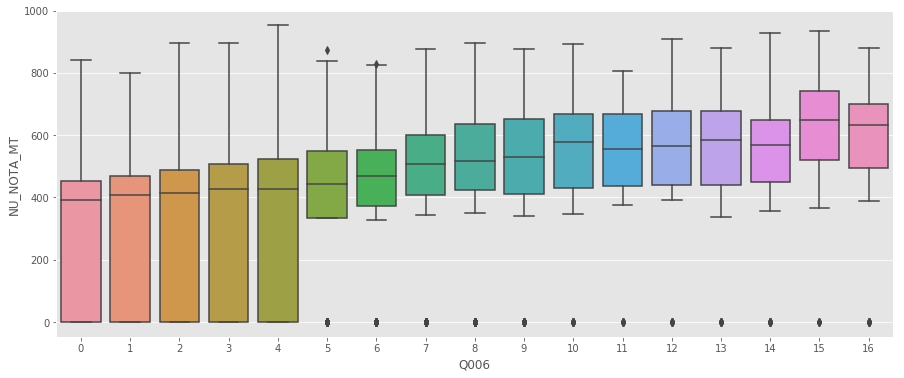

<Figure size 432x288 with 0 Axes>

In [51]:
ax, fig = plt.subplots(figsize=(15, 6))

sns.boxplot(x='Q006', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### TP_LINGUA

Corresponde à língua estrangeira escolhida pelo aluno no ENEM, onde:

- `0`: inglês
- `1`: espanhol

Não há nulos.

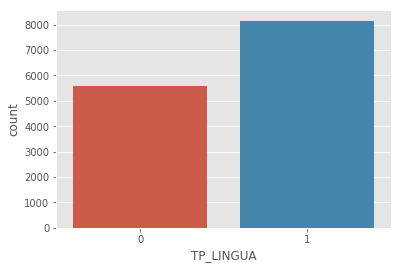

<Figure size 432x288 with 0 Axes>

In [52]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.countplot(x='TP_LINGUA', data=df)
plt.show()
plt.clf()

In [53]:
df.groupby('TP_LINGUA').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
TP_LINGUA,,,,,,,,
0,5579.0,386.913587,235.959216,0.0,349.95,444.5,540.05,952.0
1,8151.0,334.997007,221.398549,0.0,0.00,411.6,483.90,840.9


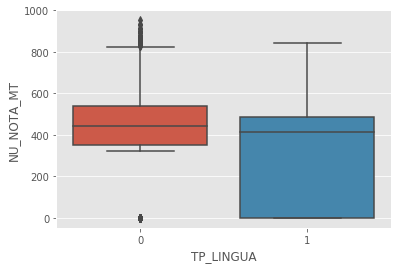

<Figure size 432x288 with 0 Axes>

In [54]:
ax, fig = plt.subplots(figsize=(6, 4))

sns.boxplot(x='TP_LINGUA', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### Q001 - Escolaridade do pai

Corresponde à pergunta "Até que série seu pai, ou o homem responsável por você, estudou?" do questionário socioeconômico, onde:

- `A`: nunca estudou
- `B`: não completou a 4ª série/5º ano do Ensino Fundamental
- `C`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `D`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `E`: completou o Ensino Médio, mas não completou a Faculdade
- `F`: completou a Faculdade, mas não completou a Pós-graduação
- `G`: completou a Pós-graduação
- `H`: não sei

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `0`: nunca estudou
- `1`: não completou a 4ª série/5º ano do Ensino Fundamental
- `2`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `3`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `4`: completou o Ensino Médio, mas não completou a Faculdade
- `5`: completou a Faculdade, mas não completou a Pós-graduação
- `6`: completou a Pós-graduação
- `7`: não sei

In [55]:
le = LabelEncoder()

df['Q001'] = le.fit_transform(df['Q001'])

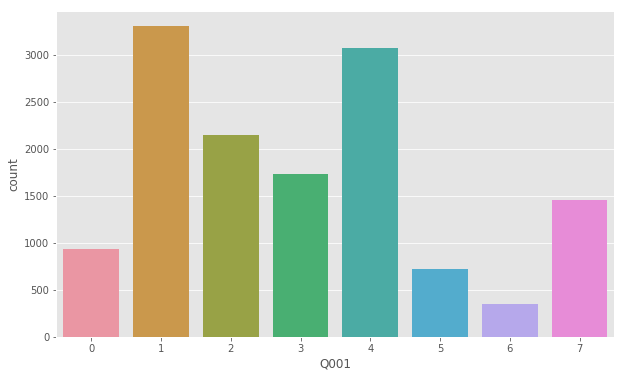

<Figure size 432x288 with 0 Axes>

In [56]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.countplot(x='Q001', data=df)
plt.show()
plt.clf()

In [57]:
df.groupby('Q001').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q001,,,,,,,,
0,934.0,290.369165,219.922946,0.0,0.000,393.30,452.375,701.4
1,3309.0,317.184467,221.120509,0.0,0.000,403.80,470.400,819.8
2,2146.0,350.173206,221.297752,0.0,0.000,419.35,496.575,895.5
3,1733.0,352.419388,226.311109,0.0,0.000,422.90,499.700,862.5
4,3079.0,392.880286,226.145958,0.0,364.550,447.70,537.200,916.6
5,719.0,470.869680,232.302155,0.0,410.850,520.10,622.400,935.1
6,354.0,480.247740,254.046839,0.0,408.725,534.65,666.150,952.0
7,1456.0,335.114973,220.182430,0.0,0.000,408.60,481.125,897.0


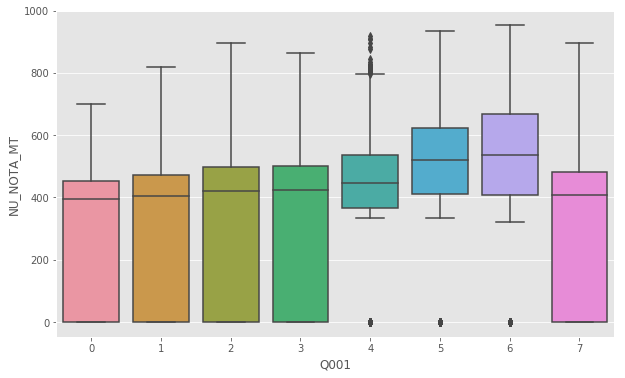

<Figure size 432x288 with 0 Axes>

In [58]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.boxplot(x='Q001', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### Q002 - Escolaridade da mãe

Corresponde à pergunta "Até que série sua mãe, ou a mulher responsável por você, estudou?" do questionário socioeconômico, onde:

- `A`: nunca estudou
- `B`: não completou a 4ª série/5º ano do Ensino Fundamental
- `C`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `D`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `E`: completou o Ensino Médio, mas não completou a Faculdade
- `F`: completou a Faculdade, mas não completou a Pós-graduação
- `G`: completou a Pós-graduação
- `H`: não sei

Não há valores nulos, mas as respostas estão representadas como letras, então terei que trasformá-las em números, onde:

- `0`: nunca estudou
- `1`: não completou a 4ª série/5º ano do Ensino Fundamental
- `2`: completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental
- `3`: completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio
- `4`: completou o Ensino Médio, mas não completou a Faculdade
- `5`: completou a Faculdade, mas não completou a Pós-graduação
- `6`: completou a Pós-graduação
- `7`: não sei

In [59]:
le = LabelEncoder()

df['Q002'] = le.fit_transform(df['Q002'])

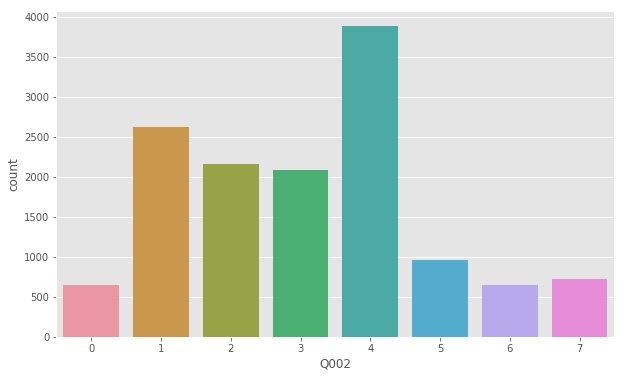

<Figure size 432x288 with 0 Axes>

In [60]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.countplot(x='Q002', data=df)
plt.show()
plt.clf()

In [61]:
df.groupby('Q002').describe()['NU_NOTA_MT']

,count,mean,std,min,25%,50%,75%,max
Q002,,,,,,,,
0,643.0,265.117885,223.424458,0.0,0.000,375.30,441.75,794.4
1,2627.0,306.881804,220.892372,0.0,0.000,398.80,463.70,851.0
2,2162.0,334.646300,221.715825,0.0,0.000,413.60,483.40,895.5
3,2083.0,342.634229,225.138757,0.0,0.000,417.30,493.90,908.8
4,3883.0,381.378161,224.509905,0.0,356.250,442.10,525.90,935.1
5,964.0,469.963382,221.931991,0.0,415.575,499.60,614.70,952.0
6,648.0,474.965278,220.476586,0.0,404.850,503.55,630.85,868.2
7,720.0,324.411389,219.280332,0.0,0.000,404.65,467.85,897.0


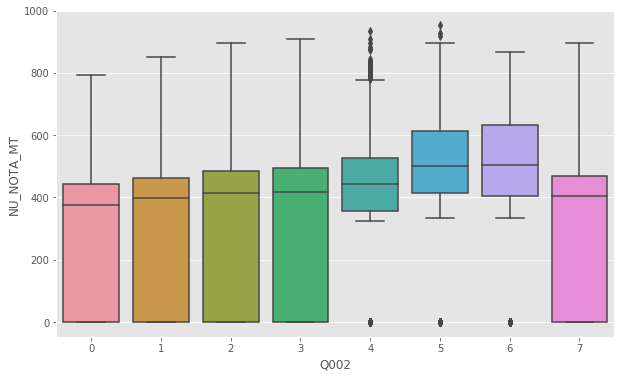

<Figure size 432x288 with 0 Axes>

In [62]:
ax, fig = plt.subplots(figsize=(10, 6))

sns.boxplot(x='Q002', y='NU_NOTA_MT', data=df)
plt.show()
plt.clf()

### NU_IDADE

Corresponde à idade do inscrito. Não há nulos.

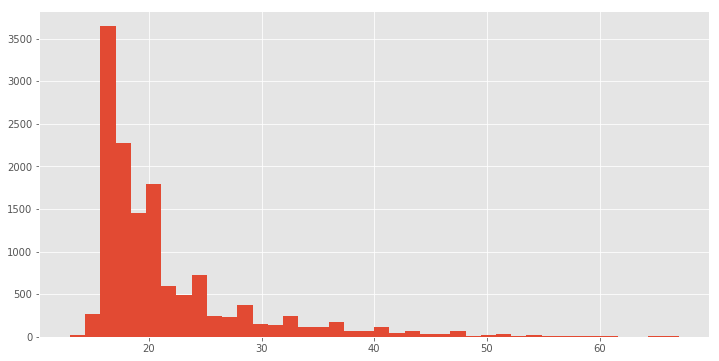

<Figure size 432x288 with 0 Axes>

In [63]:
df['NU_IDADE'].hist(bins=40, figsize=(12, 6))
plt.show()
plt.clf()

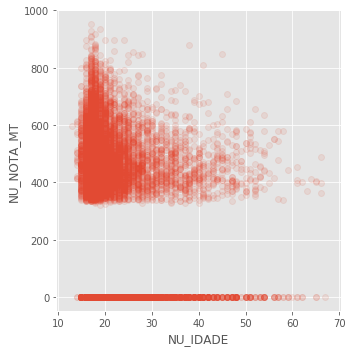

<Figure size 432x288 with 0 Axes>

In [64]:
sns.lmplot(x='NU_IDADE', y='NU_NOTA_MT', data=df,
           fit_reg=False, scatter_kws={'alpha':0.1})
plt.show()
plt.clf()

## Train test split

Antes de começar a criar nossos modelos, vamos separar nosso DataFrame em um de treino e um de teste.

In [65]:
X_df = df.drop('NU_NOTA_MT', axis=1)
y_df = df['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=0)

## Regressão linear - Baseline

Para ter um baseline (`_bl`), vou começar com uma regressão linear muito simples, usando apenas as notas que o aluno obteve nas outras provas para prever sua nota na prova de matemática.

In [66]:
X_train_bl = X_train[['NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']]
X_test_bl = X_test[['NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']]

In [67]:
lr_bl = LinearRegression(fit_intercept=False)
lr_bl.fit(X_train_bl, y_train)
predictions_lr_bl = lr_bl.predict(X_test_bl)

Note o uso de `fit_intercept=False` acima. Faço isso para que alguns indivíduos não fiquem com notas negativas, e sim com nota `0`.

In [68]:
lr_bl.score(X_test_bl, y_test)

0.8996153050106224

Podemos ver que mesmo este modelo muito simples já nos consegue um R2 de cerca de 90%.

## LGBM - Baseline

Agora vou usar um modelo mais complexo. Vou usar um modelo de gradient boosting, o [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

Por curiosidade, vou primeiro usar o LightGBM nas mesmas features da minha regressão linear acima e ver como os dois modelos se comparam, depois vou usar o LightGBM com um conjunto maior de features.

In [69]:
lgbm_bl = LGBMRegressor(random_state=0)
lgbm_bl.fit(X_train_bl, y_train)
predictions_lgbm_bl = lgbm_bl.predict(X_test_bl)

In [70]:
lgbm_bl.score(X_test_bl, y_test)

0.9175277807370835

Vemos que, com os parâmetros padrão do LightGBM, já conseguimos um modelo com R2 de quase 92%, o que é quase 2% melhor do que havíamos conseguido com a regressão linear.

## LGBM - Selected features

Agora vamos usar todas as features que havíamos inicialmente selecionado (*selected features* ou `sf`) para treinar nosso modelo usando o LightGBM.

In [71]:
lgbm_sf = LGBMRegressor(random_state=0)
lgbm_sf.fit(X_train, y_train)
predictions_lgbm_sf = lgbm_sf.predict(X_test)

In [72]:
lgbm_sf.score(X_test, y_test)

0.9237650984487598

Utilizando todas as features que havíamos inicialmente selecionado, e com os parâmetros padrão do LightGBM, conseguimos melhorar o R2 do modelo em cerca de 0.5%. No próximo notebook vamos tunar os hiperparâmetros desse nosso modelo usando random search e grid search para conseguir uma performance melhor.

## Random forest

Agora vamos testar um modelo de random forest e ver como ele se compara ao LightGBM.

In [73]:
rf_sf = RandomForestRegressor(random_state=0)
rf_sf.fit(X_train, y_train)
predictions_rf_sf = rf_sf.predict(X_test)

In [74]:
rf_sf.score(X_test, y_test)

0.9146419333923821

Vemos que o LightGBM (pelo menos com os parâmetros padrão) consegue uma acurácia maior que um random forest.

## Resposta do desafio

O desafio disponibiliza um arquivo `test.csv` para validar nosso modelo e ranquear os participantes na competição.

In [75]:
data_resposta = pd.read_csv('test.csv', header=0)

Criando um DataFrame do arquivo de testes apenas com as features que eu usei no meu modelo:

In [76]:
feat_cols_resposta = feat_cols.copy()
feat_cols_resposta.remove('NU_NOTA_MT')

df_resposta = data_resposta[feat_cols_resposta]

df_resposta.head()

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,NU_NOTA_REDACAO,Q001,Q002,Q006,Q026
0,22,F,3,1,1,5,1,NaN,0,464.8,443.5,431.8,0,420.0,B,A,C,C
1,26,F,3,1,1,8,1,NaN,0,391.1,491.1,548.0,1,580.0,E,B,C,B
2,21,M,1,1,2,0,2,3.0,0,595.9,622.7,613.6,0,320.0,E,E,D,A
3,27,F,3,1,1,8,1,NaN,0,NaN,NaN,NaN,0,NaN,H,E,G,A
4,18,M,1,1,2,0,2,1.0,0,592.9,492.6,571.4,1,320.0,D,H,H,A


Agora precisamos tratar os dados do arquivo de teste da mesma maneira que tratamos os dados do arquivo de treino, que foi basicamente tratar os nulos, converter variáveis categóricas para números e converter dtypes:

In [77]:
# TP_ENSINO
df_resposta['TP_ENSINO'] = df_resposta['TP_ENSINO'].fillna(-1)
df_resposta['TP_ENSINO'] = df_resposta['TP_ENSINO'].astype('int')

# NU_NOTA_X
NU_NOTA_X_resposta = ['NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN']
df_resposta[NU_NOTA_X_resposta] = df_resposta[NU_NOTA_X_resposta].fillna(0.0)

# Q026
le = LabelEncoder()
df_resposta['Q026'] = le.fit_transform(df_resposta['Q026'])

# TP_SEXO
le = LabelEncoder()
df_resposta['TP_SEXO'] = le.fit_transform(df_resposta['TP_SEXO'])

# Q006
le = LabelEncoder()
df_resposta['Q006'] = le.fit_transform(df_resposta['Q006'])

# Q001
le = LabelEncoder()
df_resposta['Q001'] = le.fit_transform(df_resposta['Q001'])

# Q002
le = LabelEncoder()
df_resposta['Q002'] = le.fit_transform(df_resposta['Q002'])

df_resposta.head()

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,NU_NOTA_REDACAO,Q001,Q002,Q006,Q026
0,22,0,3,1,1,5,1,-1,0,464.8,443.5,431.8,0,420.0,1,0,2,2
1,26,0,3,1,1,8,1,-1,0,391.1,491.1,548.0,1,580.0,4,1,2,1
2,21,1,1,1,2,0,2,3,0,595.9,622.7,613.6,0,320.0,4,4,3,0
3,27,0,3,1,1,8,1,-1,0,0.0,0.0,0.0,0,0.0,7,4,6,0
4,18,1,1,1,2,0,2,1,0,592.9,492.6,571.4,1,320.0,3,7,7,0


E, finalmente, gerando nossas respostas para o arquivo de teste:

In [78]:
# Predict answers to test.csv based on LightGBM model
predictions_resposta = lgbm_sf.predict(df_resposta)

Ajustando para exatamente zero as notas previstas pelo nosso modelo como negativas ou muito baixas.

In [79]:
predictions_resposta = [0 if i<20 else i for i in predictions_resposta]

E gerando o arquivo de resposta:

In [80]:
nu_inscricao = data_resposta[['NU_INSCRICAO']]
nu_nota_mt = pd.DataFrame(predictions_resposta, index=data_resposta.index, columns=['NU_NOTA_MT'])

answer = nu_inscricao.join(nu_nota_mt)
answer.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,432.241461
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,453.690137
2,b38a03232f43b11c9d0788abaf060f7366053b6d,587.933864
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,587.382067


In [81]:
answer.to_csv('answer.csv', index=False)